In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm
import glob

from dask.distributed import Client

In [2]:
client = Client(n_workers=28)
client

<Client: 'tcp://127.0.0.1:46135' processes=28 threads=28, memory=125.20 GiB>

In [3]:
base = '/g/data/ik11/outputs/'
# IAF runs:
runs = {'JRA55 IAF 1-deg':{'base':base+'access-om2/1deg_jra55_iaf_era5comparison','color':'C0','chunks':{'grid_yu_ocean':100}},
        'ERA5 IAF 1-deg':{'base':base+'access-om2/1deg_era5_iaf','color':'C1','chunks':{'grid_yu_ocean':100}},
        'JRA55 IAF 025-deg':{'base':base+'access-om2-025/025deg_jra55_iaf_era5comparison','color':'C2','chunks':{'grid_yu_ocean':108}},
        'ERA5 IAF 025-deg':{'base':base+'access-om2-025/025deg_era5_iaf','color':'C3','chunks':{'grid_yu_ocean':108}}
       }

## Date range for each experiment

In [4]:
for ekey in runs.keys():
    ds = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-scalar*.nc')))
    start = ds.time.isel(time=0)
    end = ds.time.isel(time=-1)
    print(ekey + ' ' + str(start.values)[:10] + ' to ' + str(end.values)[:10])

JRA55 IAF 1-deg 1959-01-02 to 2020-01-01
ERA5 IAF 1-deg 1960-01-02 to 2019-01-01
JRA55 IAF 025-deg 1980-01-02 to 2023-08-01
ERA5 IAF 025-deg 1980-01-02 to 2023-08-01


## Scalar diagnostics

In [5]:
def plot_timeseries(variable,keys=runs.keys()):
    plt.figure(figsize=(10,5))
    for ekey in keys:
        ds = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-scalar*.nc')))
        var = ds[variable]#.resample(time='1M').mean()
        var.plot(label=ekey,color=runs[ekey]['color'])
    plt.xlabel('Time (years)')
    plt.legend()
    return

Text(0.5, 1.0, 'Total Kinetic Energy')

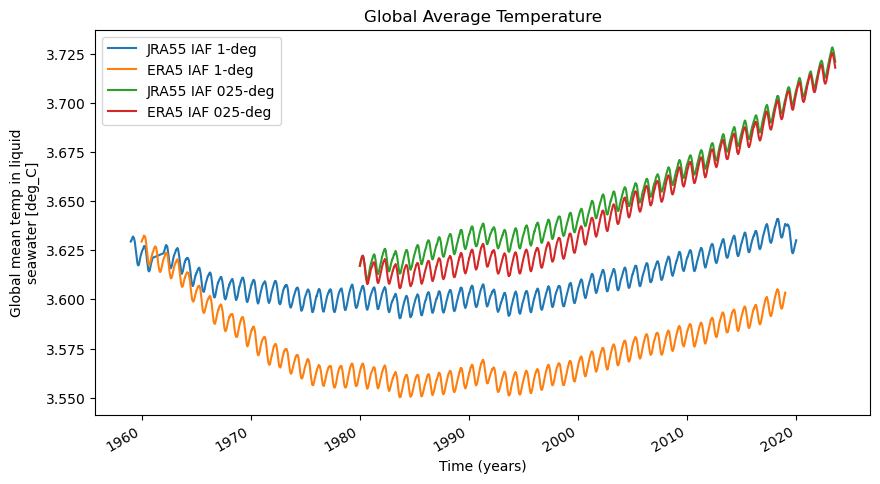

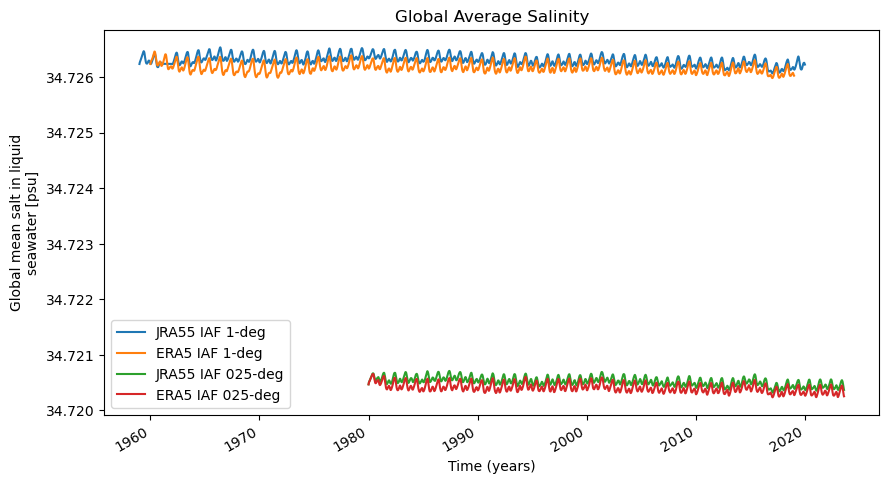

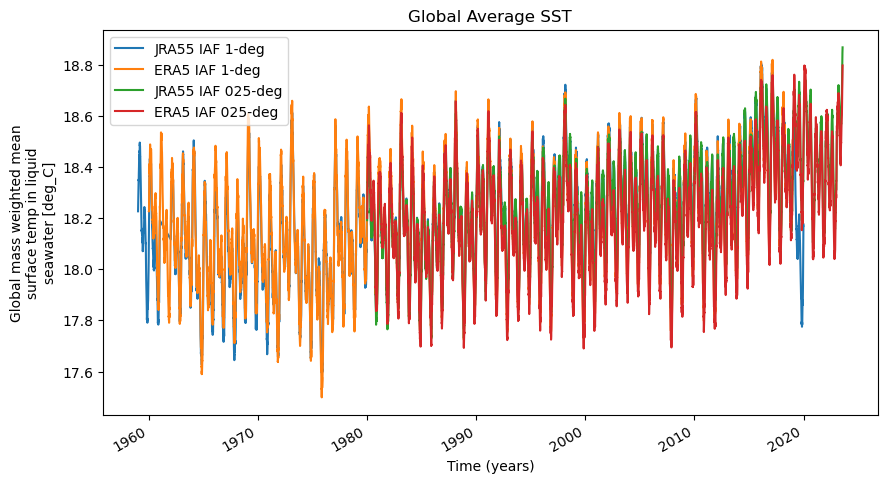

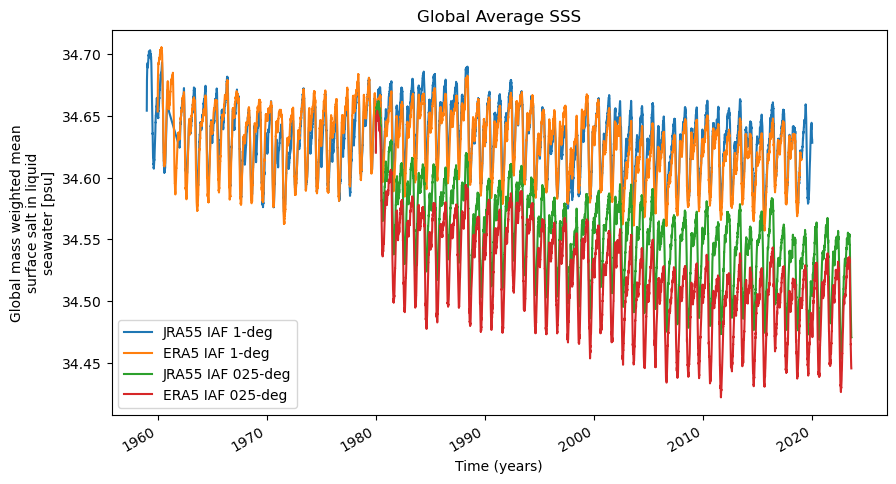

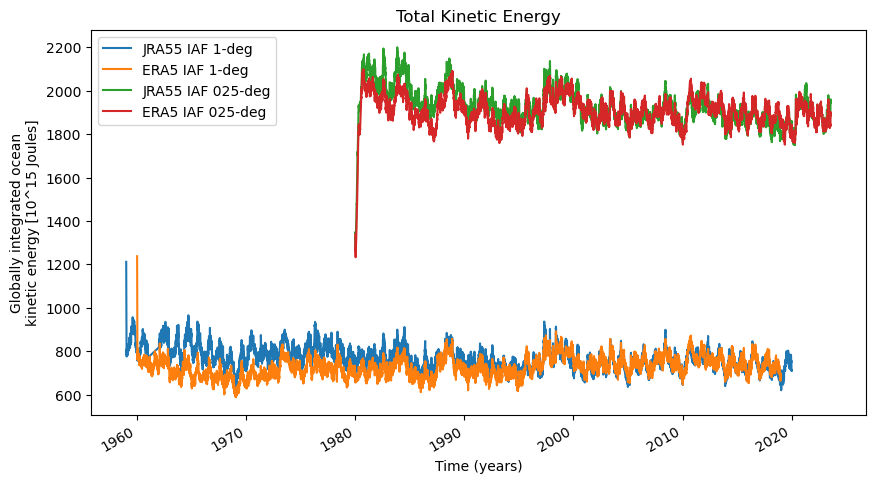

In [6]:
plot_timeseries('temp_global_ave')
plt.title('Global Average Temperature')
plot_timeseries('salt_global_ave')
plt.title('Global Average Salinity')
plot_timeseries('temp_surface_ave')
plt.title('Global Average SST')
plot_timeseries('salt_surface_ave')
plt.title('Global Average SSS')
plot_timeseries('ke_tot')
plt.title('Total Kinetic Energy')

## Circulation Diagnostics

### Drake Passage Transport

JRA55 IAF 1-deg
ERA5 IAF 1-deg
JRA55 IAF 025-deg
ERA5 IAF 025-deg
CPU times: user 10.8 s, sys: 2.14 s, total: 13 s
Wall time: 20.7 s


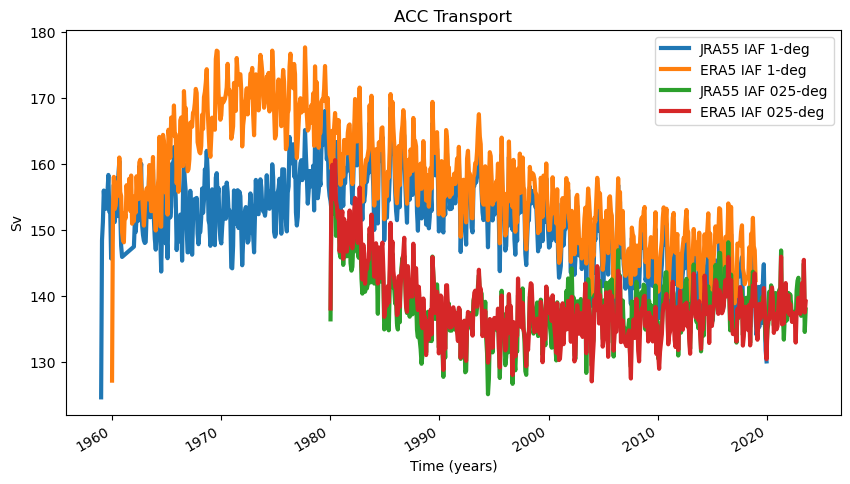

In [20]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in runs.keys():
    print(ekey)
    ds = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-2d-tx_trans_int_z-1-monthly-mean*.nc')))
    var = ds[variable]
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean')/1e6/1036
    #DP.resample(time='Y').mean().plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
    DP.plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
plt.title("ACC Transport")
plt.xlabel('Time (years)')
plt.ylabel('Sv')
plt.legend()

### AMOC Overturning in density space @ 26°N

Doing JRA55 IAF 1-deg year 000 of 060
Doing JRA55 IAF 1-deg year 010 of 060
Doing JRA55 IAF 1-deg year 020 of 060
Doing JRA55 IAF 1-deg year 030 of 060
Doing JRA55 IAF 1-deg year 040 of 060
Doing JRA55 IAF 1-deg year 050 of 060
Doing ERA5 IAF 1-deg year 000 of 058
Doing ERA5 IAF 1-deg year 010 of 058
Doing ERA5 IAF 1-deg year 020 of 058
Doing ERA5 IAF 1-deg year 030 of 058
Doing ERA5 IAF 1-deg year 040 of 058
Doing ERA5 IAF 1-deg year 050 of 058
Doing JRA55 IAF 025-deg year 000 of 043
Doing JRA55 IAF 025-deg year 010 of 043
Doing JRA55 IAF 025-deg year 020 of 043
Doing JRA55 IAF 025-deg year 030 of 043
Doing JRA55 IAF 025-deg year 040 of 043
Doing ERA5 IAF 025-deg year 000 of 043
Doing ERA5 IAF 025-deg year 010 of 043
Doing ERA5 IAF 025-deg year 020 of 043
Doing ERA5 IAF 025-deg year 030 of 043
Doing ERA5 IAF 025-deg year 040 of 043
CPU times: user 3min 2s, sys: 48.8 s, total: 3min 50s
Wall time: 9min 41s


Text(0.5, 1.0, 'AMOC (rho) at 26N')

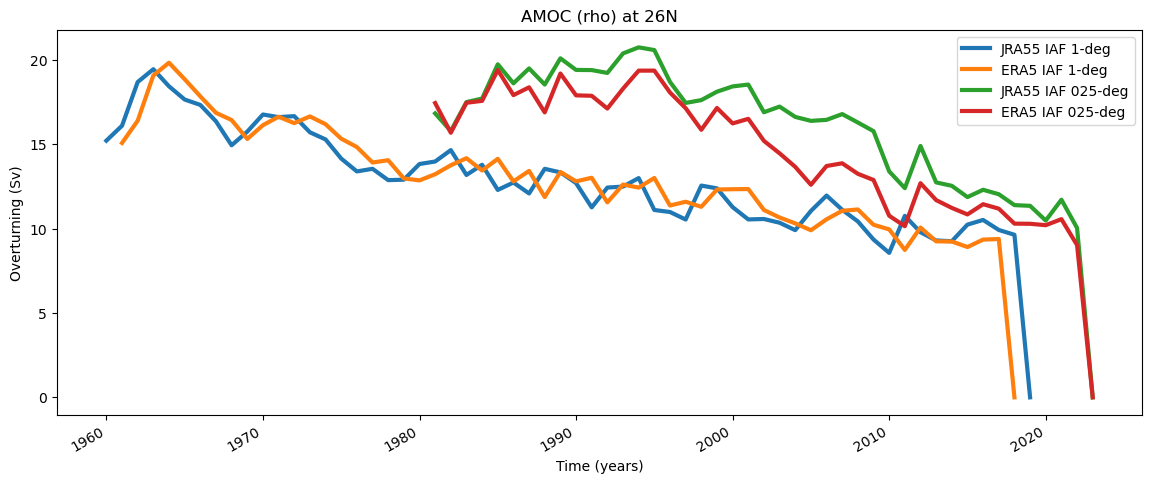

In [4]:
%%time
latitude=26.
plt.figure(figsize=(14,5))
for ekey in runs.keys():
    ds1 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])
    ds2 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho_gm-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])

    var_out = xr.zeros_like(ds1.time.resample(time='Y').mean()).astype('float').isel(time=slice(0,-1))
    for i in range(len(var_out.time)-1):
        if ((i % 10) == 0):
            print('Doing ' + ekey + ' year %03d of %03d' % (i,len(var_out.time)))
        ds1_year = ds1.isel(time=slice(i*12,(i+1)*12))
        ds2_year = ds2.isel(time=slice(i*12,(i+1)*12))
        psi_amoc = ds1_year['ty_trans_rho'].sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
        psi_amoc_gm = ds2_year['ty_trans_rho_gm'].sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_amoc_sum = psi_amoc_sum + psi_amoc_gm
        psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho')
        var_out[i] = psi_amoc_sum.mean('time').values
    var_out.plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()
plt.title('AMOC (rho) at 26N')

### AABW overturning circulation @ 55°S

In [ ]:
%%time
latitude=-55
plt.figure(figsize=(14,5))
for ekey in runs.keys():
    ds1 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])
    ds2 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho_gm-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])

    var_out = xr.zeros_like(ds1.time.resample(time='Y').mean()).astype('float').isel(time=slice(0,-1))
    for i in range(len(var_out.time)-1):
        if ((i % 10) == 0):
            print('Doing ' + ekey + ' year %03d of %03d' % (i,len(var_out.time)))
        ds1_year = ds1.isel(time=slice(i*12,(i+1)*12))
        ds2_year = ds2.isel(time=slice(i*12,(i+1)*12))
        psi_aabw = ds1_year['ty_trans_rho'].sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
        psi_aabw_gm = ds2_year['ty_trans_rho_gm'].sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
        psi_aabw_sum = psi_aabw_sum + psi_aabw_gm
        psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho')
        var_out[i] = psi_aabw_sum.mean('time').values
    var_out.plot(color=runs[ekey]['color'],linewidth=3.,label=ekey)
plt.title('AABW Cell')
plt.xlabel('Time (years)')
plt.ylabel('Overturning (Sv)')
plt.legend()

Doing JRA55 IAF 1-deg year 000 of 060
Doing JRA55 IAF 1-deg year 010 of 060
Doing JRA55 IAF 1-deg year 020 of 060
Doing JRA55 IAF 1-deg year 030 of 060
Doing JRA55 IAF 1-deg year 040 of 060
Doing JRA55 IAF 1-deg year 050 of 060
Doing ERA5 IAF 1-deg year 000 of 058
Doing ERA5 IAF 1-deg year 010 of 058


## Global Overturning Streamfunction (density)

In [10]:
def plot_psi(psi_avg, clev=np.arange(-25,25,1.)):    
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1032))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

JRA55 IAF 1-deg
ERA5 IAF 1-deg
JRA55 IAF 025-deg
ERA5 IAF 025-deg


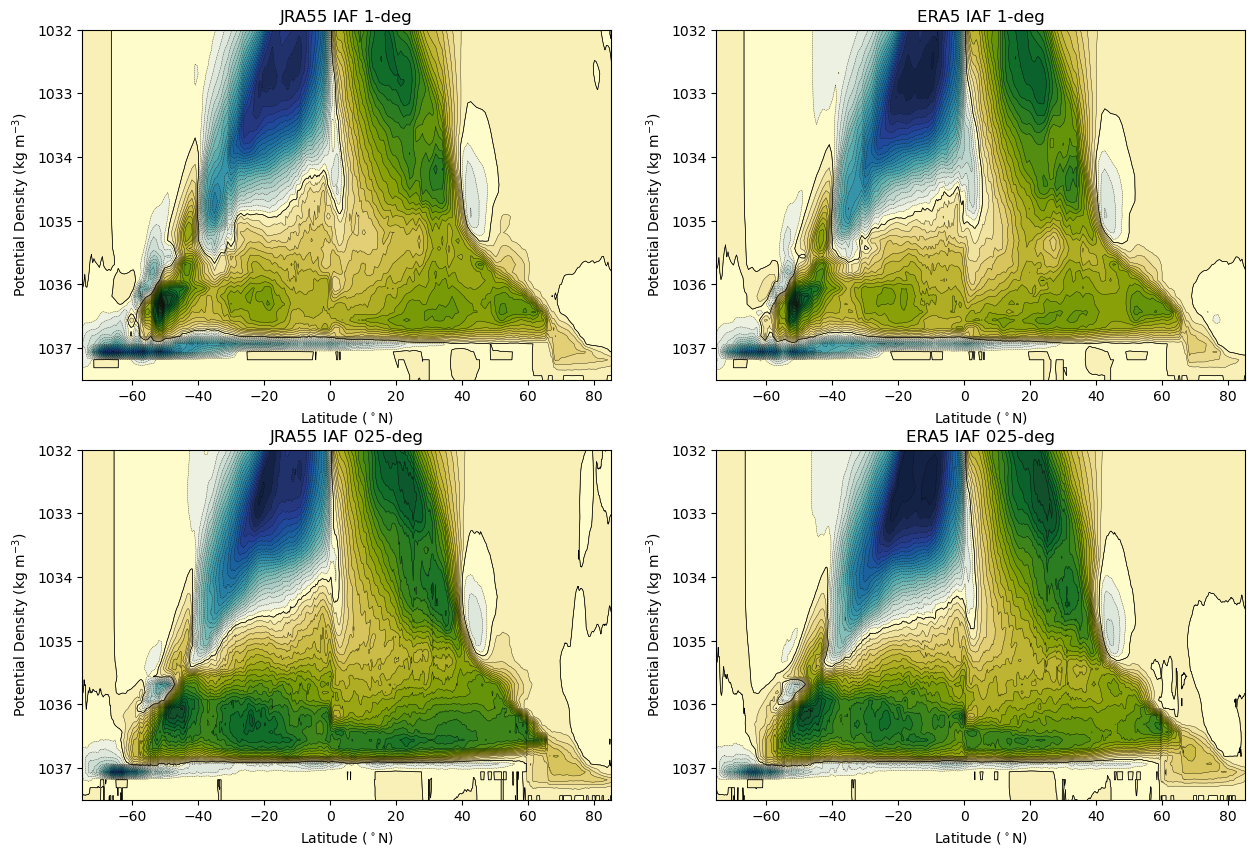

In [6]:
plt.figure(figsize=(15,10))
ii=0
keys = runs.keys()
times = slice('2008-01-01','2010-01-01')
for ekey in keys:
    ii+=1
    print(ekey)
    ds1 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])
    ds2 = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-3d-ty_trans_rho_gm-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])

    psi = ds1['ty_trans_rho'].sel(time=times).mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    psi_gm = ds2['ty_trans_rho_gm'].sel(time=times).mean('time').sum('grid_xt_ocean')*1.0e-9
    psi_avg = psi_avg + psi_gm
    psi_avg.load()
    
    plt.subplot(2,2,ii)
    p1 = plot_psi(psi_avg)
    plt.title(ekey)

### Ice Area (in both hemispheres)

#### All runs:

JRA55 IAF 1-deg
ERA5 IAF 1-deg
JRA55 IAF 025-deg
ERA5 IAF 025-deg


Text(0.5, 1.0, 'Southern Ocean')

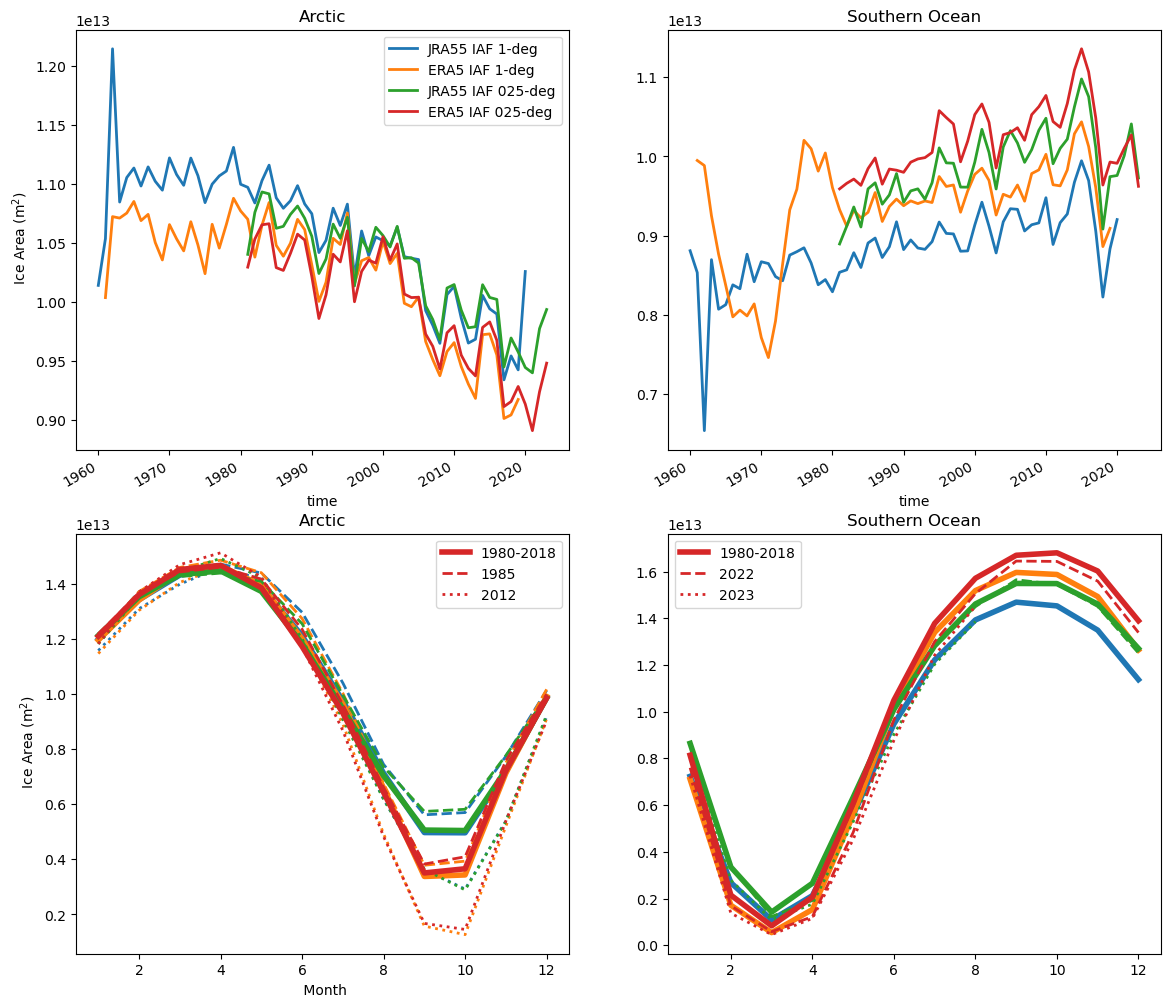

In [11]:
variable='aice_m'
fig,axes = plt.subplots(2,2,figsize=(14,12))
for ekey in runs.keys():
    print(ekey)
    
    lt = sorted(glob.glob(runs[ekey]['base'] + '/output***/ice/OUTPUT/iceh.*.nc'))
    lt = [item for item in lt if 'daily' not in item]
    ds = xr.open_mfdataset(lt, concat_dim="time", combine="nested",
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True)
    var = ds['aice_m']
    area_t = xr.open_dataset(runs[ekey]['base'] + '/output000/ocean/ocean-2d-area_t.nc')['area_t']
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    
    #NH_area.plot(ax=axes[0],label=ekey,color=runs[ekey]['color'])
    #SH_area.plot(ax=axes[1],label=ekey,color=runs[ekey]['color'])
    NH_area.resample(time='Y').mean().isel(time=slice(0,-1)).plot(ax=axes[0][0],color=runs[ekey]['color'],linewidth=2.,label=ekey)
    SH_area.resample(time='Y').mean().isel(time=slice(0,-1)).plot(ax=axes[0][1],color=runs[ekey]['color'],linewidth=2.)

    NH_all = NH_area.sel(time=slice('1980','2018')).groupby('time.month').mean()
    SH_all = SH_area.sel(time=slice('1980','2018')).groupby('time.month').mean()
    if (ekey == 'ERA5 IAF 025-deg'):
        axes[1][0].plot(np.arange(1,13),NH_all.values,color=runs[ekey]['color'],linewidth=4.,label='1980-2018')
        axes[1][1].plot(np.arange(1,13),SH_all.values,color=runs[ekey]['color'],linewidth=4.,label='1980-2018')
    else:
        axes[1][0].plot(np.arange(1,13),NH_all.values,color=runs[ekey]['color'],linewidth=4.)
        axes[1][1].plot(np.arange(1,13),SH_all.values,color=runs[ekey]['color'],linewidth=4.)
    lstys = ['--',':','-.']
    lwids = [1,2,3]
    for i,year in enumerate([1985,2012]):
        NH_sc = NH_area.sel(time=slice(str(year) + '-01-01',str(year) + '-12-31'))
        if (len(NH_sc) != 0):
            if (ekey == 'ERA5 IAF 025-deg'):
                axes[1][0].plot(np.arange(1,len(NH_sc)+1),NH_sc.values,color=runs[ekey]['color'],linewidth=2.,linestyle=lstys[i],label=str(year))
            else:
                axes[1][0].plot(np.arange(1,len(NH_sc)+1),NH_sc.values,color=runs[ekey]['color'],linewidth=2.,linestyle=lstys[i])
        else:
            pass
    for i,year in enumerate([2022,2023]):
        SH_sc = SH_area.sel(time=slice(str(year) + '-01-01',str(year) + '-12-31'))
        if (len(SH_sc) != 0):
            if (ekey == 'ERA5 IAF 025-deg'):
                axes[1][1].plot(np.arange(1,len(SH_sc)+1),SH_sc.values,color=runs[ekey]['color'],linewidth=2.,linestyle=lstys[i],label=str(year))
            else:
                axes[1][1].plot(np.arange(1,len(SH_sc)+1),SH_sc.values,color=runs[ekey]['color'],linewidth=2.,linestyle=lstys[i])
        else:
            pass
        
axes[0][0].set_ylabel(' Ice Area (m$^2$)')
axes[0][0].legend()
axes[0][0].set_title('Arctic')
axes[0][1].set_title('Southern Ocean')
axes[1][0].set_ylabel(' Ice Area (m$^2$)')
axes[1][0].set_xlabel(' Month')
axes[1][0].legend()
axes[1][1].legend()
axes[1][0].set_title('Arctic')
axes[1][1].set_title('Southern Ocean')

#### Just 025 in the Southern Ocean for 2023 sea ice:

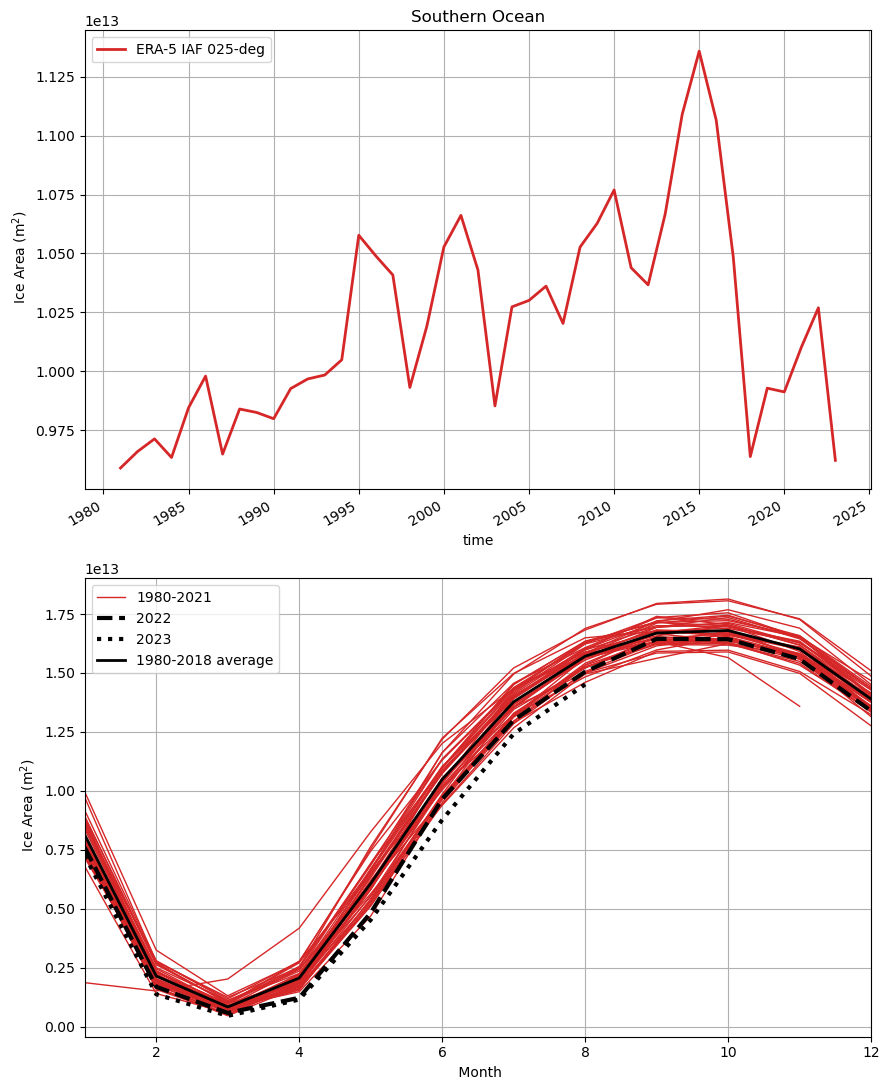

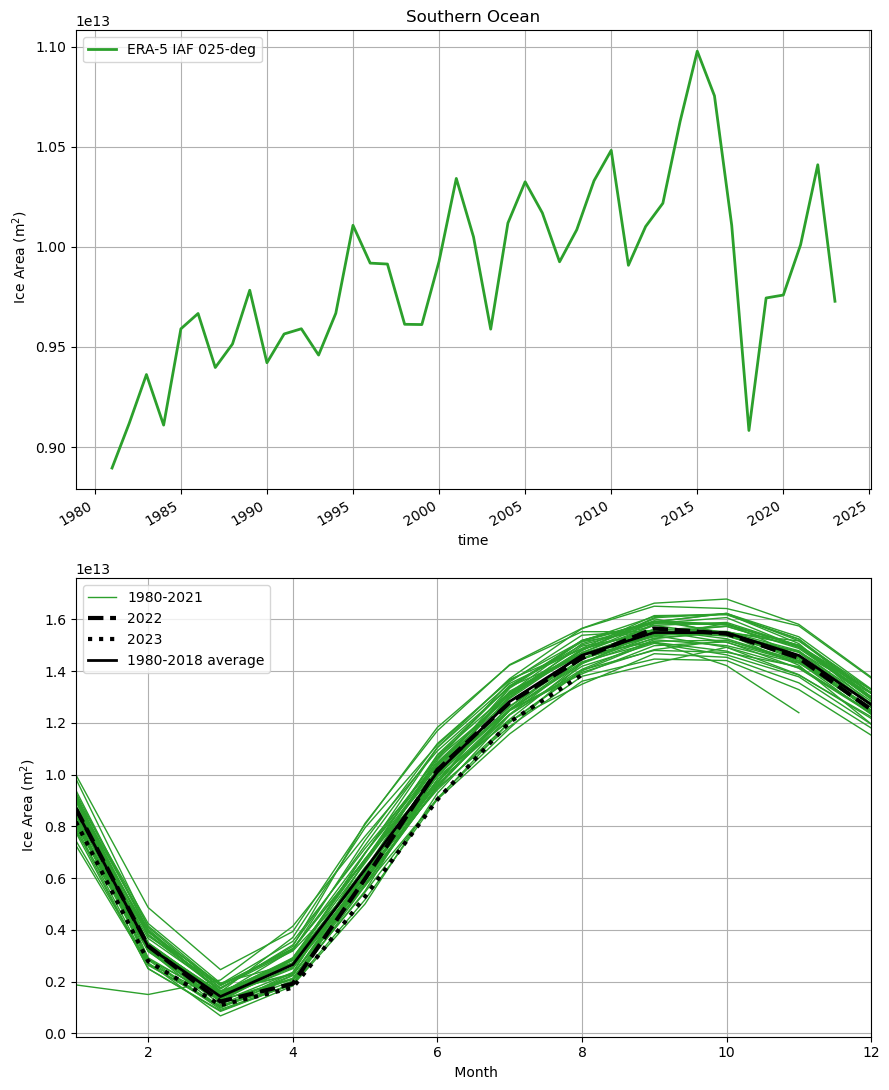

In [13]:
variable='aice_m'
ekeys = ['ERA5 IAF 025-deg','JRA55 IAF 025-deg']

for ekey in ekeys:
    
    fig,axes = plt.subplots(2,1,figsize=(9,11))

    lt = sorted(glob.glob(runs[ekey]['base'] + '/output***/ice/OUTPUT/iceh.*.nc'))
    lt = [item for item in lt if 'daily' not in item]
    ds = xr.open_mfdataset(lt, concat_dim="time", combine="nested",
                             data_vars='minimal', coords='minimal', compat='override',
                             parallel=True)
    var = ds['aice_m']
    area_t = xr.open_dataset(runs[ekey]['base'] + '/output000/ocean/ocean-2d-area_t.nc')['area_t']
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()

    SH_area.resample(time='Y').mean().isel(time=slice(0,-1)).plot(ax=axes[0],label='ERA-5 IAF 025-deg',color=runs[ekey]['color'],linewidth=2.)

    SH_all = SH_area.sel(time=slice('1980','2018')).groupby('time.month').mean()

    lstys = ['--',':']
    lcols = ['k','k']
    lwids = [3,3]

    SH_sc = SH_area.sel(time=slice(str(year) + '-01-01',str(1990) + '-12-31'))
    axes[1].plot(np.arange(1,len(SH_sc)+1),SH_sc.values,color=runs[ekey]['color'],linewidth=1.,label='1980-2021')      
    for i,year in enumerate(np.arange(1980,2021)):
        SH_sc = SH_area.sel(time=slice(str(year) + '-01-01',str(year) + '-12-31'))
        if (len(SH_sc) != 0):
            axes[1].plot(np.arange(1,len(SH_sc)+1),SH_sc.values,color=runs[ekey]['color'],linewidth=1.)
        else:
            pass

    for i,year in enumerate([2022,2023]):
        SH_sc = SH_area.sel(time=slice(str(year) + '-01-01',str(year) + '-12-31'))
        if (len(SH_sc) != 0):
            axes[1].plot(np.arange(1,len(SH_sc)+1),SH_sc.values,color=lcols[i],linewidth=lwids[i],linestyle=lstys[i],label=str(year))
        else:
            pass
    axes[1].plot(np.arange(1,13),SH_all.values,color='k',linewidth=2.,label='1980-2018 average')
    axes[0].set_ylabel(' Ice Area (m$^2$)')
    axes[0].legend()
    axes[0].set_title('Southern Ocean')
    axes[0].grid()
    axes[1].set_ylabel(' Ice Area (m$^2$)')
    axes[1].set_xlabel(' Month')
    axes[1].legend()
    axes[1].grid()
    axes[1].set_xlim([1,12])
    plt.tight_layout()
    #plt.savefig('ERA5_IAF_025deg_Southern_Ocean_Sea_Ice_Area.png',dpi=100)

# Surface fluxes:

JRA55 IAF 1-deg tau_x
JRA55 IAF 1-deg lw_heat
JRA55 IAF 1-deg net_sfc_heating
JRA55 IAF 1-deg pme_river
JRA55 IAF 1-deg sens_heat
JRA55 IAF 1-deg swflx
JRA55 IAF 1-deg evap_heat
ERA5 IAF 1-deg tau_x
ERA5 IAF 1-deg lw_heat
ERA5 IAF 1-deg net_sfc_heating
ERA5 IAF 1-deg pme_river
ERA5 IAF 1-deg sens_heat
ERA5 IAF 1-deg swflx
ERA5 IAF 1-deg evap_heat
JRA55 IAF 025-deg tau_x
JRA55 IAF 025-deg lw_heat
JRA55 IAF 025-deg net_sfc_heating
JRA55 IAF 025-deg pme_river
JRA55 IAF 025-deg sens_heat
JRA55 IAF 025-deg swflx
JRA55 IAF 025-deg evap_heat
ERA5 IAF 025-deg tau_x
ERA5 IAF 025-deg lw_heat
ERA5 IAF 025-deg net_sfc_heating
ERA5 IAF 025-deg pme_river
ERA5 IAF 025-deg sens_heat
ERA5 IAF 025-deg swflx
ERA5 IAF 025-deg evap_heat


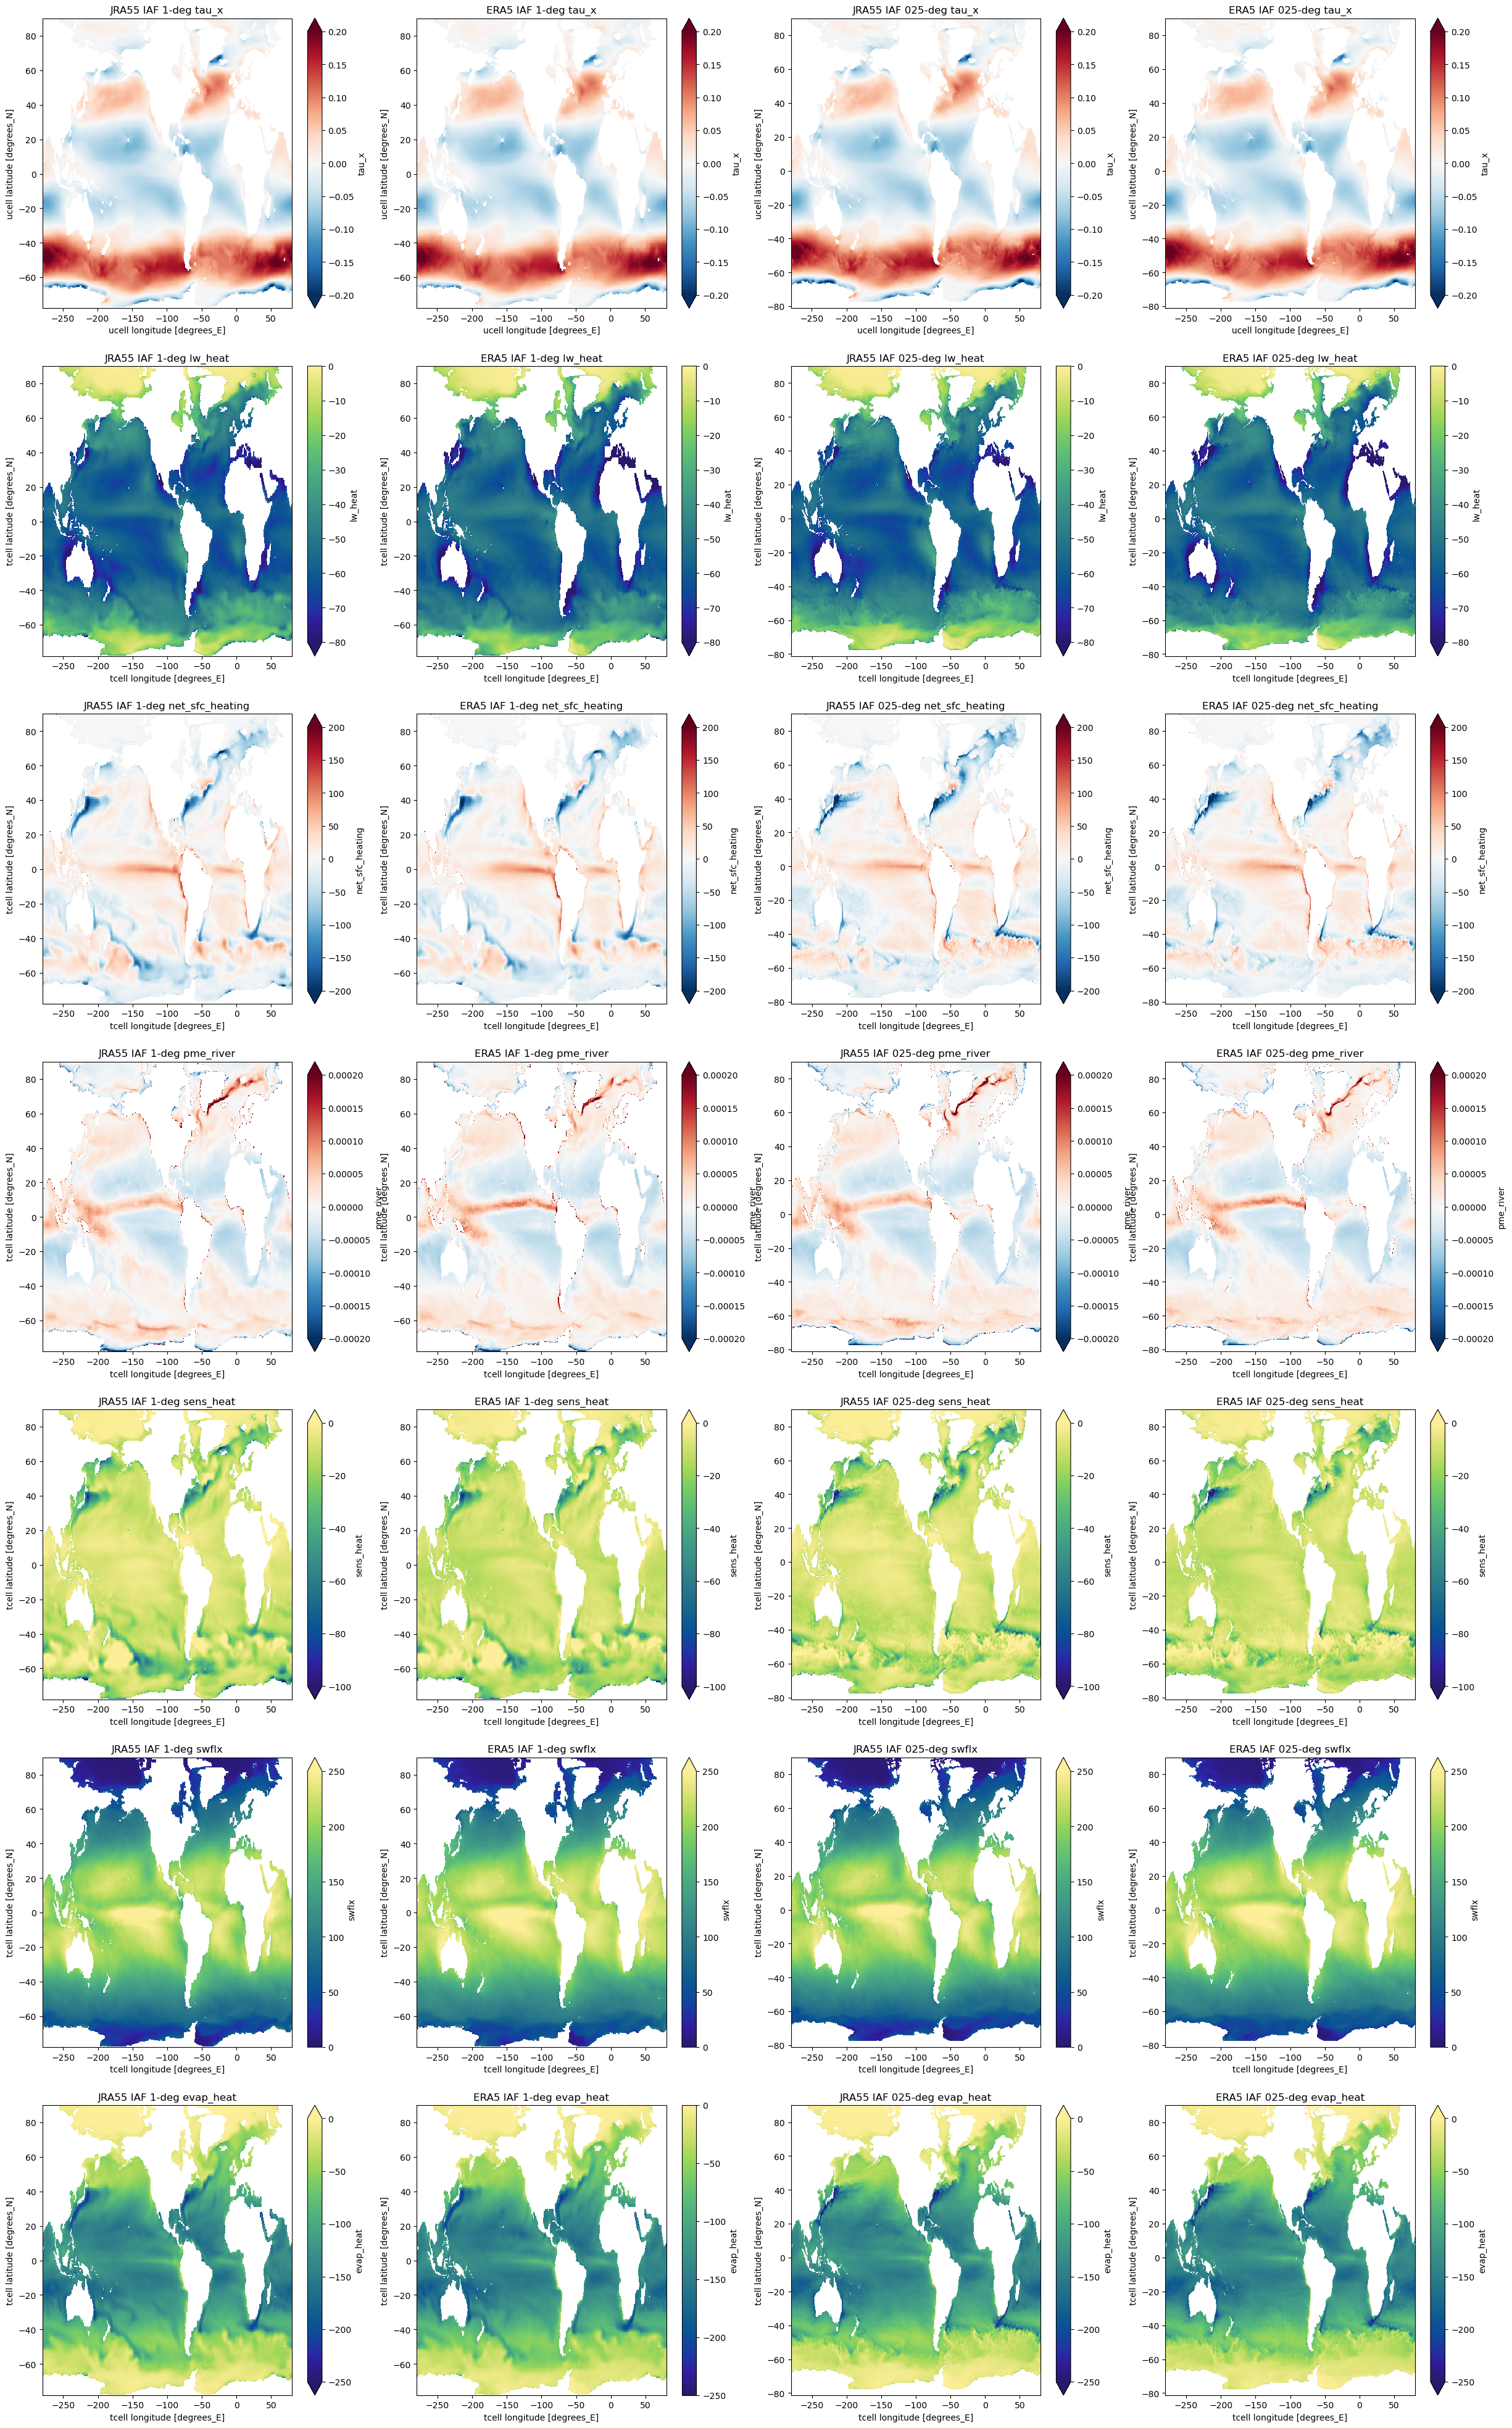

In [11]:
fig, axes = plt.subplots(nrows=7,ncols=4,figsize=(30,50))

vs = {'tau_x':{'vmin':-0.2,'vmax': 0.2,'cmap':'RdBu_r'},
      'lw_heat':{'vmin':-80.,'vmax': 0.,'cmap':cm.cm.haline},
      'net_sfc_heating':{'vmin':-200.,'vmax': 200.,'cmap':'RdBu_r'},
      'pme_river':{'vmin':-0.0002,'vmax': 0.0002,'cmap':'RdBu_r'},
      'sens_heat':{'vmin':-100.,'vmax': 0.,'cmap':cm.cm.haline},
      'swflx':{'vmin':0.,'vmax': 250.,'cmap':cm.cm.haline},
      'evap_heat':{'vmin':-250.,'vmax': 0.,'cmap':cm.cm.haline}}

times = slice('2009-01-01','2010-01-01')

for i, ekey in enumerate(runs.keys()):
    for j,v in enumerate(vs.keys()):
        print(ekey + ' ' + v)
        var = xr.open_mfdataset(sorted(glob.glob(runs[ekey]['base'] + '/output***/ocean/ocean-2d-' + v + '-1-monthly-mean*.nc')),chunks=runs[ekey]['chunks'])[v]
        #cc.querying.getvar(expt,v,session,frequency='1 monthly').sel(time=slice(times[0],times[1])).mean('time')
        var.sel(time=times).mean('time').plot(ax=axes[j][i],vmin=vs[v]['vmin'],vmax=vs[v]['vmax'],cmap=vs[v]['cmap'])
        axes[j][i].set_title(ekey + ' ' + v)